# Keras를 사용한 ML(머신러닝) 기본사항
## 4. 회귀
### - 자동차 연비 예측하기
#### 참고사이트 : https://www.tensorflow.org/tutorials/keras/regression?hl=ko

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib

import matplotlib.pyplot as plt # 시각화 라이브러리(다양한 데이터를 많은 방법으로 도식화)
import pandas as pd # 데이터 분석 라이브러리(대용량 데이터 처리에 적합)
import seaborn as sns # 산점도 행렬 그리기 위함

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [2]:
# Augo MPG 데이터셋 다운로드(UCI 머신러닝 저장소에서 다운로드)
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/kismi/.keras/datasets/auto-mpg.data'

In [3]:
# pandas 활용
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail() # 0~397까지 총 398x8 행렬로 데이터 구성

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
# 해당 값이 결측치인지(결측치면 True, 아니면 False) 확인하기 위해 isna() 메소드 사용
# 즉, dataset의 결측치를 확인하고 각 항목에 대해 합을 구함(Horsepower에 6개 있음)
# https://writeline-codename.tistory.com/entry/%EA%B2%B0%EC%86%90-%EB%8D%B0%EC%9D%B4%ED%84%B0Missing-Data-%EC%B2%98%EB%A6%AC%ED%95%98%EA%B8%B0
dataset.isna().sum() # 결측(손)치란, column에 값이 없는 것을 의미

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# dropna() 함수는 결손치(NaN)가 있는 항목은 모두 삭제하는 역할
dataset = dataset.dropna()

In [6]:
origin = dataset.pop('Origin') # Origin 열은 수치형이 아닌 범주형이므로 one-hot encoding으로 변환

In [7]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [8]:
# 데이터셋을 훈련세트와 테스트세트로 분할하기
train_dataset = dataset.sample(frac=0.8,random_state=0) # sample 함수를 사용해 원본 데이터에서 정해진 비율만큼(frac) 랜덤으로 뽑아오기
test_dataset = dataset.drop(train_dataset.index)

In [9]:
# 397개의 데이터 중 80%만 랜덤하게 추출함
print(train_dataset)

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
146  28.0          4          90.0        75.0  2125.0          14.5   
282  22.3          4         140.0        88.0  2890.0          17.3   
69   12.0          8         350.0       160.0  4456.0          13.5   
378  38.0          4         105.0        63.0  2125.0          14.7   
331  33.8          4          97.0        67.0  2145.0          18.0   
..    ...        ...           ...         ...     ...           ...   
281  19.8          6         200.0        85.0  2990.0          18.2   
229  16.0          8         400.0       180.0  4220.0          11.1   
150  26.0          4         108.0        93.0  2391.0          15.5   
145  32.0          4          83.0        61.0  2003.0          19.0   
182  28.0          4         107.0        86.0  2464.0          15.5   

     Model Year  USA  Europe  Japan  
146          74  1.0     0.0    0.0  
282          79  1.0     0.0    0.0  
69           72  1.0 

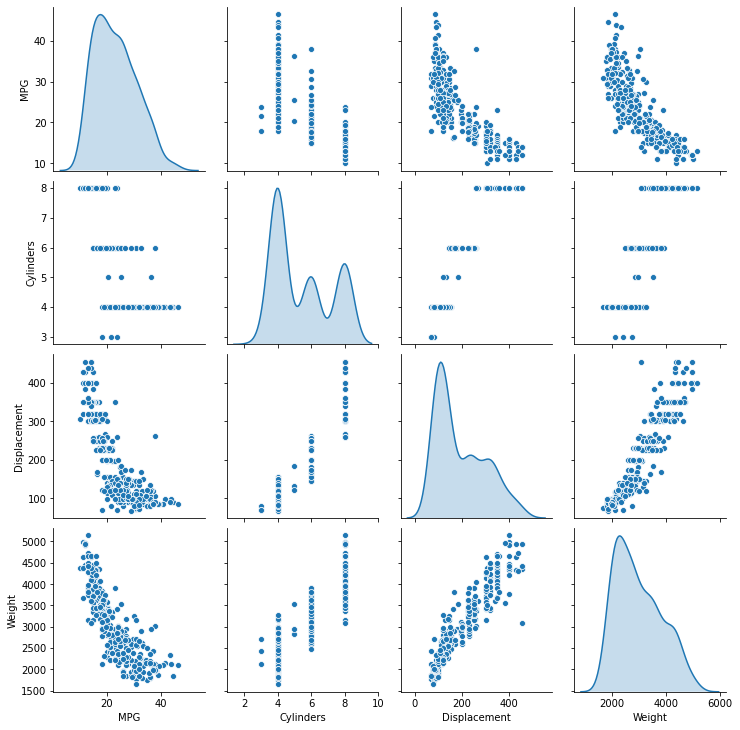

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [12]:
# 전반적인 통계치도 확인
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [13]:
# 특정 값(label)을 분리해 이걸 예측하기 위해 모델을 훈련
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [14]:
# 데이터 정규화
# train_stats를 보고 각 특성의 범위가 얼마나 다른지 확인(다 다름)
# 특성의 크기와 범위가 다르면 normalization(정규화)이 권장(안해도 되지만, 훈련시키기 어렵고 입력단위에 의존적인 모델이 만들어지기에 권장)
# 아래 함수에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 one-hot encoding과 마찬가지로 모델에 주입되는 모든 데이터에 적용되야 함. 
# 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함.
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [15]:
# 모델 만들기
# 위에서 생성된 정규화된 데이터를 사용해 모델을 훈련
# 두 개의 완전 연결(densely connected) 은닉층으로 Sequential 모델 생성
# 출력층은 하나의 연속적인 값을 반환
# 추후 두 번째 모델을 쉽게 만들기 위해 build_model 함수 생성
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [16]:
model = build_model()

In [17]:
model.summary() # 모델에 대한 간단한 정보 출력

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 훈련세트에서 10개의 sample을 하나의 batch로 만들어 model.predict 메서드 호출
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch) # 이거 쓰려면 반드시 tensorflow 버전이 2.0.0이어야 함
example_result # 결과값은 -1~1 사이의 정규화된 데이터 배열로 출력

array([[ 0.20838249],
       [ 0.02616927],
       [ 0.33209595],
       [ 0.19683391],
       [ 0.17890836],
       [-0.0294318 ],
       [ 0.1374775 ],
       [ 0.40802756],
       [ 0.04312328],
       [ 0.17642003]], dtype=float32)

In [19]:
# 모델 훈련(1000번의 epoch 동안 학습)
# epoch가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시하며,
# 훈련 정확도와 검증 정확도는 history 객체에 기록
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.184050,0.967501,2.184050,8.401100,2.268980,8.401100,995
996,2.245309,1.004030,2.245310,8.724752,2.291446,8.724751,996
997,2.219035,0.961828,2.219034,8.861752,2.320980,8.861752,997
998,2.204408,0.934037,2.204408,8.407250,2.242956,8.407249,998
999,2.029673,0.943514,2.029673,8.984828,2.295199,8.984827,999


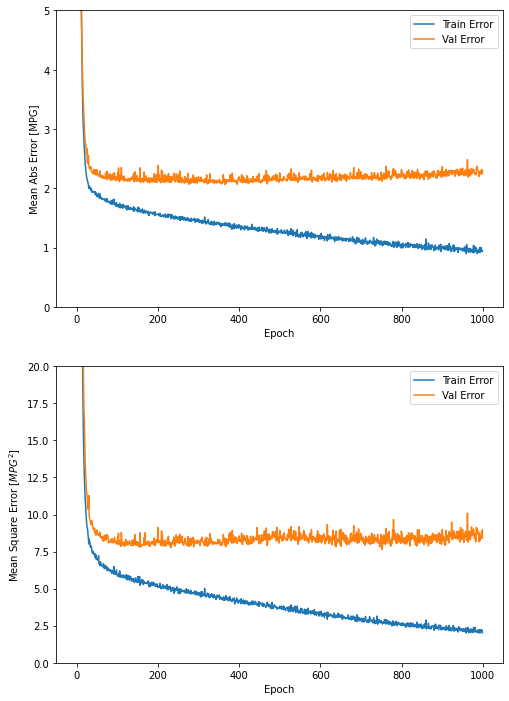

In [23]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


..................................................................................................

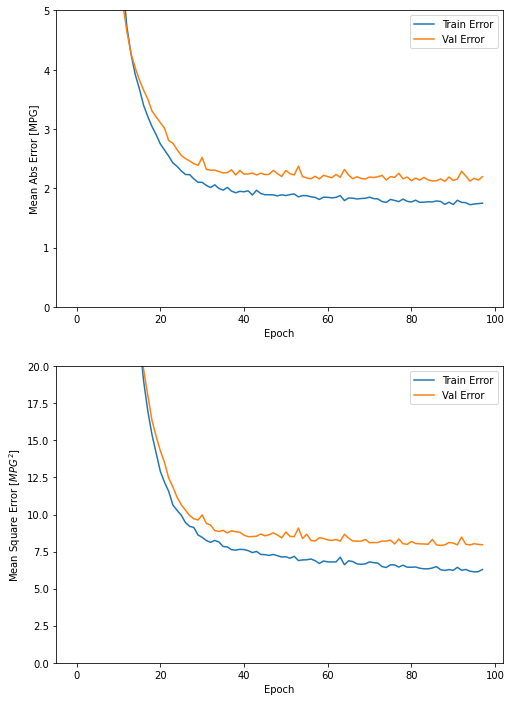

In [24]:
# 위에 출력된 그래프를 보면 수백번 epoch를 진행한 이후 모델이 거의 향상되지 않음.
# 검증점수가 향상되지 않으면 자동훈련(학습)을 멈추도록 model.fit 메서드 수정
# epoch마다 상태 점검을 위해 EarlyStopping callback을 사용
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [25]:
# 모델 훈련 시 사용하지 않았던 test set에서 모델의 성능 확인
# 이를 통해 모델이 실전에 투입되었을 때 모델의 성능 짐작 가능
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.4729 - mae: 1.7786 - mse: 5.4729
테스트 세트의 평균 절대 오차:  1.78 MPG


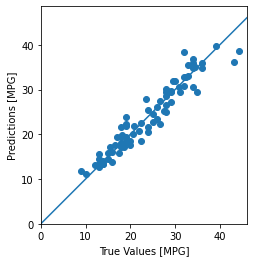

In [26]:
# 예측
# 테스트 세트에 있는 sample을 사용해 MPG 값 예측
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


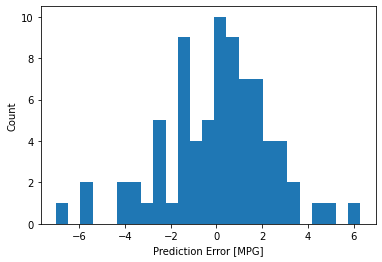

In [28]:
# 오차의 분포
# 정규분포(가우시안분포)가 아닌 이유는 sample의 수가 매우 작기때문(- -6, 4, 6 에 조금씩 올라와있는거)
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

이 튜토리얼은 회귀 문제를 위한 기법을 소개합니다.

* 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수입니다(분류 문제에서 사용하는 손실 함수와 다릅니다).
* 비슷하게 회귀에서 사용되는 평가 지표도 분류와 다릅니다. 많이 사용하는 회귀 지표는 평균 절댓값 오차(MAE)입니다.
* 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 합니다.
* 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋습니다.
* 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법입니다.